# Data Acquisition of Polytec vibrometer


This script connects to a NI USB-6363 Data Acquisition board to generate an actuation signal, and measure the respective vibrometer data of a Polytec MSA-500 system


1. Actuation signal is generated by the DAQ
2. A copy reference of the actuation signal is acquired by the DAQ
3. The physical actuation signal is amplified and drives the device under test
4. The Polytec MSA-500 is configured using the system software, and the Detector and other configurations must be defined in this script
5. The script loop generates the actuation signal, and measures the corresponding reference and vibrometer signal
6. The acquired signal and configuration settings are stored in a json file

In [1]:
%load_ext autoreload

%autoreload 2


import numpy as np
import matplotlib.pyplot as plt
import os

from scipy import constants as const
import nidaqmx as ni

import time
# Creating the actuation signal
from datetime import datetime
import json
from json import JSONEncoder

from scipy import signal, fft
from matplotlib import colors

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

    
    
    
import sounddevice as sd
import numpy as np
import scipy.io.wavfile as wav
from scipy import interpolate


import re


In [2]:

def progress_bar(progress, bar_length=20, bar_character='#'):
    """
    Progress bar.
    Writes a progress bar in place in the output
    
    Args:
        progress: value between 0 and 1
        bar_length: number of characters to consider in the bar
    """
    
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
#     clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( bar_character * block + "-" * (bar_length - block), progress * 100)
    if progress <1:
        end = '\r'
    else:
        end = "\n"
    print(text, end=end) 

In [3]:
def open_data_file(filename):
    # Load data from json file
    with open(filename, 'r') as fp:
        json_dict = json.load(fp)
    return json_dict
        
def load_frequency_response(filename):
    """Opens the data file and extracts frequency and amplitude"""
    data = open_data_file(filename)
    
    frequencies = np.array(data['signal_frequencies'])
    amplitude = np.array(data['vibrometer_amplitude'])
    return (frequencies, amplitude)

def load_frequency_deflection_spectrum(filename):
    """ Opens the data file, calcualtes the spectrum and returns spectrometer data"""
    data = open_data_file(filename)


    # Looping over signal and calculating FFT for each
    vibration_spectrum = []

    frequencies = np.array(data['signal_frequencies'])
    for i, frequency in enumerate(data['signal_frequencies']):
        vibrometer = data['signal'][str(i)]['vibrometer']
        ref_I = data['signal'][str(i)]['ref_I']
        time = data['signal_time']

        dt = np.diff(time[:2])
        vib_fft = fft.fft(vibrometer, )

        vibration_freqs = fft.fftfreq(vib_fft.size, d=dt)
        vib_fft = fft.fftshift(vib_fft)
        vibration_freqs = fft.fftshift(vibration_freqs)


        vibration_spectrum.append(vib_fft)
        # plt.plot(freqs,vib_fft)


    vibration_spectrum = np.array(vibration_spectrum).T

    spectrum_abs = np.abs(fft_list)
    spectrum_phase = np.angle(fft_list)
    
    return (frequencies, vibration_freqs, vibration_spectrum)


    
def load_time_signal_data_concatenated(filename):
    """ Opens the data file, reads signal data and concatenates in a single time signal"""
    data = open_data_file(filename)

    vibrometer_list = []
    ref_I_list = []
    for i, frequency in enumerate(data['signal_frequencies']):
        vibrometer = np.array(data['signal'][str(i)]['vibrometer'])
        vibrometer_list.append(vibrometer)
        ref_I = data['signal'][str(i)]['ref_I']

    vibrometer = np.array(vibrometer_list).flatten()
    
    time = np.arange(len(vibrometer))*data['daq_input_sample_interval']
    
    return (time, vibrometer)

In [4]:
# Audio recording function definition
def record_audio(device_str="", fs=192000, duration=0.5, verbose=True):
    """Record audio from device and returns the array corresponding to the recorded clip
    
    Parameters:
        device_str : default "Line (UMIK-2), MME", string to match the device obtained with sd.query_devices()
        fs : default 192000, sampling frequency of the audio signal
        duration: default 0.5s, duration of the recroded clip
        
    Returns:
        dt : delta time beween each sample
        recording : np.array of recorded audio clip
    
    """
    device_list = sd.query_devices()
    
    for device in device_list:
        device_index = -1
        # print(device)
        if device_str in device["name"]:
            device_name = device["name"]
            device_index = device["index"]
            break
    if device_index <0:
        print(device_list)
        raise Exception("%s not found in device list: "%(device_str))
        return (None, None)
    
    if verbose:
        print("Selected device:",device_index,device_name)
    sd.default.device = device_index



    fs_recording = fs
    dt_recording = 1/fs_recording
    # duration = 0.5 #

    N_recording = int(fs_recording*duration)

    # Start recording:

    recording = sd.rec(N_recording, samplerate=fs_recording, channels=1, dtype='float64')
    time_recording = np.arange(len(recording))*dt_recording

    # wait for recording to complete
    sd.wait()
    
    return (recording.flatten(), dt_recording)


def recording2spectrum(recording, dt, norm_amplitude=True):
    """Calculates the real spectrum of the recording 
    
    """
    rec_fft = np.abs(np.fft.rfft(recording))
    rec_freqs = np.fft.rfftfreq(recording.size, d=dt)
    # rec_fft = np.fft.fftshift(rec_fft)
    # rec_freqs = np.fft.fftshift(rec_freqs)
    
    if norm_amplitude:
        rec_fft = 2/rec_fft.size * rec_fft
    
    return (rec_freqs, rec_fft)


def load_umik_calibration_function(filename):
    
    with open(filename) as f:
        first_line = f.readline()

    gain_data = re.split(', | =|dB', first_line)
    gain_data, gain_data[1], gain_data[4]

    sens_factor = float(gain_data[1])
    a_gain = float(gain_data[4])
    sens_factor, a_gain

    sensitivity_dBFS = sens_factor-a_gain # dBFS/Pa
    sensitivity_FS_Pa = np.power(10, sensitivity_dBFS/20) # relative to FS per Pa
    reference_dBSPL = 94
    
    
    f, calib = np.loadtxt(filename, skiprows=1, unpack=True)
    
    calibration_correction = sensitivity_dBFS - calib + reference_dBSPL

    
    calibration_function = interpolate.interp1d(f, calibration_correction, fill_value="extrapolate")

    # plt.plot(f, calib)
    # plt.xlabel("Frequency [Hz]")
    # plt.ylabel("Calibration correction [dB]")
    # plt.title(filename)
    """
    
    The cal file sensitivity figure is the dBFS input reading for 100 dB SPL with the input volume set to 100%, which is 24 dB of digital gain. 
    The UMIK internal gain (18 dB in your case) is taken into account in the cal file sensitivity figure, 
    so your UMIK with the internal gain set to 0 dB would need a sensitivity figure of -18.673 dB.
    https://www.hometheatershack.com/threads/understanding-spl-offset-umik-1.134857/

    There is an article here www.analog.com/en/analog-dialogue/articl...one-sensitivity.html
    For digital microphones such as the UMIK-2 the sensitivity number is the digital output level relative to full scale when the SPL is 94dB.
    This is the standard way of specifying it with 94dB being the reference level, I believe that the UMIK-2 conforms to this way of specifying it but the UMIK-1 does not.
    https://www.minidsp.com/forum/umik-questions/19208-understanding-the-umik-2-calibration-file
    
    
    
    https://www.roomeqwizard.com/help/help_en-GB/html/calfiles.html
     Calibration File Format
    The calibration file is a plain text file which by default has the extension .cal, though other extensions are also accepted.
    It should contain the actual gain (and optionally phase) response of the meter or microphone at the frequencies given, these will then be subtracted from subsequent measurements. 
    The values in the calibration file can be separated by spaces, tabs or commas. Typically the values are relative to the level at some reference frequency, 
    e.g. 1kHz, so the gain value there is 0.0.
    
    Mic sensitivity calibration data
    USB microphone cal files will typically have a line at the start of the file that defines their sensitivity, of the form:

    "Sens Factor =1.2345dB, SERNO: XXXXXXX"
    The sens factor figure is usually the input dBFS reading the mic will produce when driven by a 94 dB calibrator with the input volume set to maximum. 
    REW can make use of this value if it also knows the relationship between the input volume setting and the gain in dB applied to the mic data, 
    as of September 2022 that is known for the UMIK-1, UMIK-2, UMIK-X, EARS, CARIO-A2B, UMM-6, Omnimic and Beta Three mics. Sens Factor entries for other devices are not used.
    
    
    raw_signal_SPL = 20*log10(raw_signalV/range_signalV) - sensitivity_dBFS - calibration_curve + reference_SPL_calibration[94dB]
    
    """


    return calibration_function


def microphone_calibrate(freq_signal, signal, calibration_function):
    
    correction_gain = calibration_function(freq_signal)
    
    signal = signal+correction_gain
    return (freq_signal, signal)


def signal2db(signal):
    return 20*np.log10(signal)
    
    
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def find_value_frequency(freqs, signal, frequency):
    """Finds the value of signal closest to the given frequency"""
    idx = find_nearest_idx(freqs, frequency)
    value = signal[idx]
    return value

    

## Linearization function

In [5]:
k = 1851
k = 2278
area = 9.3e-8
gap = 2e-6
mass = 2.17e-9 #kg

def linearization_function(x, gain=53, k=1851, area=9.3e-8, gap=2e-6):
    a = np.sqrt(2*k*x/(const.epsilon_0*area))*(gap-x)/gain
    
    return a



def generate_waveform_signal(t, frequency, max_displacement):
    A = max_displacement/2
    x = A+A*np.cos(2*np.pi*t*frequency-np.pi)

    sig = linearization_function(x)
    # data = V

    N_samples = len(x)

    # print("max voltage:",max(sig), "samples",N_samples, "freq", frequency)
    return sig

def generate_sinusoidal_signal(t, frequency, voltage):
    A = voltage/2
    x = A+A*np.cos(2*np.pi*t*frequency-np.pi)

    sig = x
    # data = V

    N_samples = len(x)
    return sig


from scipy.optimize import curve_fit

def fit_amplitude_response(w, F0, k, w0, Q):
    return np.abs(F0)/k/(np.sqrt( np.power(1-np.power(w/w0,2),2) + np.power(w/(Q*w0),2) ))




In [6]:
filename = "calibration/calibration_8101247.txt"


Text(0.5, 1.0, 'calibration/calibration_8101247.txt')

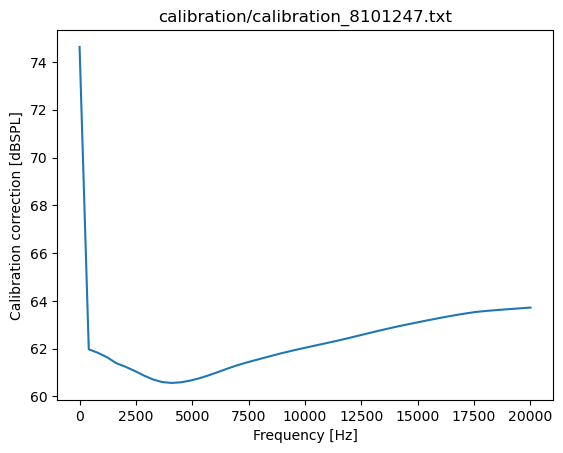

In [7]:

filename = "calibration/calibration_8101247.txt"

calibration_function = load_umik_calibration_function(filename)
f = np.linspace(0,20e3)
calibration_correction = calibration_function(f)

plt.figure()
plt.plot(f, calibration_correction)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Calibration correction [dBSPL]")
plt.title(filename)


# Evaluate linearization k

## Run this first to estimate the k for a given Voltage used in the linearization function

1. Set the sinusoidal signal voltage 
2. Loop over the frequency range
3. Fit to the second order system
4. Extract $\omega_0$ and Q
5. Calculate the $k = m \omega_0^2$

In [8]:
output_path = 'DAQ_outputs//'

frequency_list = np.linspace(1,200,200)*1e3
# frequency_list = np.array([1,2,5,10,20,50,100])*1e3

# select the displacement/voltage value expected at dc
# max_displacement = 20*1e-9
max_voltage = 20 #V

data_dict = dict()

data_dict['device_name'] = "FDPanel_T09_F10.1_bottom"

filename = data_dict['device_name']+"_linearization_%0.1fV"


data_dict['date'] = "%s"%datetime.now()

data_dict['linearization_model_k'] = -1
data_dict['linearization_model_mass'] = mass
data_dict['linearization_model_area'] = area
data_dict['linearization_model_area'] = gap
data_dict['linearization_model_voltage'] = max_voltage


# "acoustic" or "interferometer"
data_dict['measurement_type'] = "linearization"


data_dict['interferometer_system'] = "Polytec MSA-500"
data_dict['interferometer_detector'] = 50e-9
data_dict['interferometer_detector_units'] = "m/V"
data_dict['interferometer_analog_filter_dc_block'] = True
data_dict['interferometer_analog_filter_lowpass'] = False
data_dict['actuation_amplifier_gain'] = 53
data_dict['actuation_max_displacement'] = -1

# data_dict['actuation_max_voltage'] = linearization_function(data_dict['actuation_max_displacement'])*data_dict['actuation_amplifier_gain']
data_dict['actuation_max_voltage'] = max_voltage

# DAQ sampling acquisition
data_dict['daq_system'] = "NI USB-6363"
# data_dict['input_channel_names'] = ["ref_I", "ref_Q", "vibrometer"]
# data_dict['daq_input_channels'] = ["Dev1/ai0", "Dev1/ai1", "Dev1/ai2"]

data_dict['daq_input_channels'] = ["Dev1/ai0", "Dev1/ai2"]
data_dict['daq_input_channel_names'] = ["ref_I", "vibrometer"]
data_dict['daq_input_fs'] = 500e3
data_dict['daq_input_number_of_samples'] = 2000
data_dict['daq_input_sample_rate'] = -1
data_dict['daq_input_sample_interval'] = -1

data_dict['daq_output_channels'] = ["Dev1/ao0"]
data_dict['daq_output_channel_names'] = ["V_actuation"]
data_dict['daq_output_fs'] = 2e6
data_dict['daq_output_waveform_periods'] = 10


data_dict['signal_frequencies'] = frequency_list
# acquired signal will be stored inside the 'signal' key
data_dict['signal'] = dict()

data_dict['vibrometer_amplitude'] = []

print("Running linearization ")
print("")
for f_i, frequency in enumerate(frequency_list):
    
    progress_bar(f_i/len(frequency_list))
    # Create actuation waveform
    fs = data_dict['daq_output_fs']
    
    t_max = data_dict['daq_output_waveform_periods']/frequency

    N = int(t_max*fs)
    t = np.linspace(0,t_max,N)

    
    # data = generate_waveform_signal(t, frequency, max_displacement)

    data = generate_sinusoidal_signal(t, frequency, max_voltage/data_dict['actuation_amplifier_gain'])
    
    with ni.Task() as read_task, ni.Task() as write_task, ni.Task() as trigger_task:

        # set channels
        for chan_input, chan_name in zip(data_dict['daq_input_channels'], data_dict['daq_input_channel_names']):
            read_task.ai_channels.add_ai_voltage_chan(chan_input, name_to_assign_to_channel=chan_name)

        for chan_output, chan_name in zip(data_dict['daq_output_channels'], data_dict['daq_output_channel_names']):
            write_task.ao_channels.add_ao_voltage_chan(chan_output, name_to_assign_to_channel=chan_name)


        # Set sampling frequency and Continuous output mode to continuously generate the same waveform
        write_task.timing.cfg_samp_clk_timing(data_dict['daq_output_fs'], sample_mode=ni.constants.AcquisitionType.CONTINUOUS)

        # Set the acquisiton sampling frequency with a finite acquisition
        read_task.timing.cfg_samp_clk_timing(data_dict['daq_input_fs'], sample_mode=ni.constants.AcquisitionType.FINITE, samps_per_chan=data_dict['daq_input_number_of_samples'])

        # Set the acquisiton trigger to start synchronized with the writing of the waveform
        
        read_task.triggers.start_trigger.cfg_dig_edge_start_trig(write_task.triggers.start_trigger.term, trigger_edge=ni.constants.Edge.FALLING)

        # set an arbitrary TICKS time after write
        wait_time_after_write = 3000000

        read_task.triggers.start_trigger.delay = wait_time_after_write
        # print(read_task.triggers.start_trigger.delay_units)

        # Write waveform data to output buffer
        write_task.write(data)

        # Get the actual sample rate and sample interval from the daq
        sample_clk_rate = read_task.timing.samp_clk_rate
        dt = 1/sample_clk_rate
        
        data_dict['daq_input_sample_rate'] = sample_clk_rate
        data_dict['daq_input_sample_interval'] = dt
        # print(sample_clk_rate, dt)

        read_task.start()

        write_task.start()

        # Read data
        read_data = read_task.read(number_of_samples_per_channel=ni.constants.READ_ALL_AVAILABLE)

        time.sleep(0.01)
        # set output to 0
        write_task.stop()
        write_task.write([0,0])
        write_task.start()
    
    data_dict['signal'][f_i] = dict()
    data_dict['signal'][f_i]['frequency'] = frequency
    for i, (sig_name, sig) in enumerate(zip(data_dict['daq_input_channel_names'], read_data)):
        data_dict['signal'][f_i][sig_name] = sig
        # print("")
        # print("signalmax", np.ptp(sig))
    data_dict['signal_time'] = np.arange(len(sig))*data_dict['daq_input_sample_interval']
    
    # scaling vibrometer signal with detector 
    data_dict['signal'][f_i]['vibrometer'] = np.array(data_dict['signal'][f_i]['vibrometer'])*data_dict['interferometer_detector']
    # data_dict['signal'][f_i]['vibrometer'] = np.max(data_dict['signal'][f_i]['vibrometer'])-data_dict['signal'][f_i]['vibrometer']
    
    # Scaling reference signal with amplifier gain
    data_dict['signal'][f_i]['ref_I'] = np.array(data_dict['signal'][f_i]['ref_I'])*data_dict['actuation_amplifier_gain']
    
    # Calculating vibrometer amplitude using 0.5-99.5 percentiles
    vibrometer_amplitude = np.percentile(data_dict['signal'][f_i]['vibrometer'],99.5)-np.percentile(data_dict['signal'][f_i]['vibrometer'], 0.5)
    # vibrometer_amplitude = np.ptp(data_dict['signal'][f_i]['vibrometer'])
    data_dict['vibrometer_amplitude'].append(vibrometer_amplitude)
progress_bar(1)

max_voltage = data_dict['actuation_max_voltage'] 

output_filename = os.path.join(output_path, "%s.json"%filename%data_dict['actuation_max_voltage'])


if 1:
    plt.figure()
    actuation_max_voltage = data_dict['actuation_max_voltage']
    # actuation_max_displacement = data_dict['actuation_max_displacement']
    
    frequencies = np.array(data_dict['signal_frequencies'])
    amplitude = np.array(data_dict['vibrometer_amplitude'])
    
    xdata,ydata = frequencies/1e3, amplitude/1e-9
    # fitting
    popt, pcov = curve_fit(fit_amplitude_response, xdata, ydata)
    
    F0,k,w0, Q = popt
    
    w0 = w0*1e3
    
    k = np.power(2*np.pi*w0,2)*mass
    fitdata = fit_amplitude_response(xdata, *popt)
    
    print('Calculated: %0.1fV k=%d, $\omega_0$=%0.1f Q=%0.2f'%(actuation_max_voltage, k, w0/1e3, Q))
    
    label = '%0.1fV k=%d, $\omega_0$=%0.1f Q=%0.2f'%(actuation_max_voltage, k, w0/1e3, Q)
    plt.plot(frequencies/1e3, amplitude/1e-9, label=label)

    plt.plot(xdata, fitdata, c='k', lw=0.5)
    
    if 'device_name' in data_dict.keys():
        title = data_dict['device_name']
        plt.title(title)
        output_figname = data_dict['device_name']+".png"
    plt.xlabel("Deflection frequency [kHz]")
    plt.ylabel("Deflection [nm]")
    plt.legend(fontsize=8)
    output_filefig = os.path.join(output_path, "%s.png"%filename%data_dict['actuation_max_voltage'])

    plt.savefig(output_filefig, dpi=300)
    data_dict['fit_model_k'] = k
    data_dict['fit_model_f0'] = w0
    data_dict['fit_model_Q'] = Q


print("Storing files to ", output_filename)

with open(output_filename, 'w') as fp:
    json.dump(data_dict, fp, cls=NumpyArrayEncoder, indent=4)

print("Complete")
    
# data_dict.keys()

Running linearization 



DaqError: Device cannot be accessed.  Possible causes:
Device is no longer present in the system.
Device is not powered.
Device is powered, but was temporarily without power.
Device and/or chassis driver support may have been removed.
Device is damaged.
Ensure the device is properly connected and turned on. Ensure the device and/or chassis is supported in the current version of the driver. Check the device's status in NI MAX. Turn the computer off and on again. If you suspect that the device is damaged, contact National Instruments at ni.com/support.
Device Specified: Dev1

Task Name: _unnamedTask<0>

Status Code: -201003

# Loop acquisition


In [ ]:

# data_dict['device_name'] = "FDPanel_T09_F5.2_top_"

# filename = data_dict['device_name']+"actuation_%0.1fV.json"
# filename

Assuming k=1758 for linearization
Running loop 

Progress: [####################] 100.0%
1758.0550330312892 1807.4180276777022
Calculated: 28.5V k=1807, $\omega_0$=145.3 Q=2.54
Storing files to  DAQ_outputs//FDPanel_T09_F10.1_top_actuation_28.5V.json
Complete


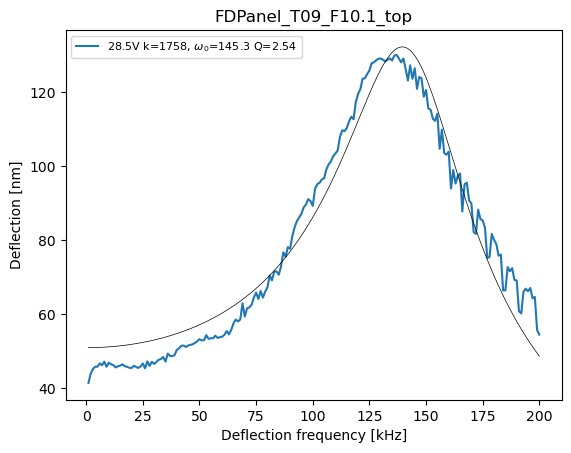

In [93]:
output_path = 'DAQ_outputs//'


# frequency_list = np.array([1,2,5,10,20,50,100,120,130,140,150])*1e3
# frequency_list = np.array([1,2,])*1e3

# displacement_list = np.array([50,100])*1e-9
# displacement_list = np.array([100])*1e-9

frequency_list = np.linspace(1,200,200)*1e3
# frequency_list = np.array([1,2,5,10,20,50,100])*1e3

# select the displacement/voltage value expected at dc
max_displacement = 50*1e-9

data_dict = dict()

data_dict['device_name'] = "FDPanel_T09_F10.1_top"

filename = data_dict['device_name']+"_actuation_%0.1fV"


data_dict['date'] = "%s"%datetime.now()

data_dict['linearization_model_k'] = k
data_dict['linearization_model_mass'] = mass
data_dict['linearization_model_area'] = area
data_dict['linearization_model_gap'] = gap


print("Assuming k=%d for linearization"%(k))

# "acoustic" or "interferometer"
data_dict['measurement_type'] = "interferometer"

data_dict['interferometer_system'] = "Polytec MSA-500"
data_dict['interferometer_detector'] = 50e-9
data_dict['interferometer_detector_units'] = "m/V"
data_dict['interferometer_analog_filter_dc_block'] = True
data_dict['interferometer_analog_filter_lowpass'] = False
data_dict['actuation_amplifier_gain'] = 53
data_dict['actuation_max_displacement'] = max_displacement



data_dict['actuation_max_voltage'] = linearization_function(data_dict['actuation_max_displacement'], 
                                                       gain=data_dict['actuation_amplifier_gain'], 
                                                       k=data_dict['linearization_model_k'], 
                                                       area=data_dict['linearization_model_area'], 
                                                       gap=data_dict['linearization_model_gap'])*data_dict['actuation_amplifier_gain']

# DAQ sampling acquisition
data_dict['daq_system'] = "NI USB-6363"
# data_dict['input_channel_names'] = ["ref_I", "ref_Q", "vibrometer"]
# data_dict['daq_input_channels'] = ["Dev1/ai0", "Dev1/ai1", "Dev1/ai2"]

data_dict['daq_input_channels'] = ["Dev1/ai0", "Dev1/ai2"]
data_dict['daq_input_channel_names'] = ["ref_I", "vibrometer"]
data_dict['daq_input_fs'] = 500e3
data_dict['daq_input_number_of_samples'] = 2000
data_dict['daq_input_sample_rate'] = -1
data_dict['daq_input_sample_interval'] = -1

data_dict['daq_output_channels'] = ["Dev1/ao0"]
data_dict['daq_output_channel_names'] = ["V_actuation"]
data_dict['daq_output_fs'] = 2e6
data_dict['daq_output_waveform_periods'] = 10


data_dict['signal_frequencies'] = frequency_list
# acquired signal will be stored inside the 'signal' key
data_dict['signal'] = dict()

data_dict['vibrometer_amplitude'] = []

print("Running loop ")
print("")
for f_i, frequency in enumerate(frequency_list):
    
    progress_bar(f_i/len(frequency_list))
    # Create actuation waveform
    fs = data_dict['daq_output_fs']
    
    t_max = data_dict['daq_output_waveform_periods']/frequency

    N = int(t_max*fs)
    t = np.linspace(0,t_max,N)

    
    # data = generate_waveform_signal(t, frequency, max_displacement)

    
    sig_sine = generate_sinusoidal_signal(t, frequency, data_dict['actuation_max_displacement'])
    sig_linearized = linearization_function(sig_sine, 
                                           gain=data_dict['actuation_amplifier_gain'], 
                                           k=data_dict['linearization_model_k'], 
                                           area=data_dict['linearization_model_area'], 
                                           gap=data_dict['linearization_model_gap'])*data_dict['actuation_amplifier_gain']
    data = sig_linearized/data_dict['actuation_amplifier_gain']
    
    with ni.Task() as read_task, ni.Task() as write_task, ni.Task() as trigger_task:

        # set channels
        for chan_input, chan_name in zip(data_dict['daq_input_channels'], data_dict['daq_input_channel_names']):
            read_task.ai_channels.add_ai_voltage_chan(chan_input, name_to_assign_to_channel=chan_name)

        for chan_output, chan_name in zip(data_dict['daq_output_channels'], data_dict['daq_output_channel_names']):
            write_task.ao_channels.add_ao_voltage_chan(chan_output, name_to_assign_to_channel=chan_name)


        # Set sampling frequency and Continuous output mode to continuously generate the same waveform
        write_task.timing.cfg_samp_clk_timing(data_dict['daq_output_fs'], sample_mode=ni.constants.AcquisitionType.CONTINUOUS)

        # Set the acquisiton sampling frequency with a finite acquisition
        read_task.timing.cfg_samp_clk_timing(data_dict['daq_input_fs'], sample_mode=ni.constants.AcquisitionType.FINITE, samps_per_chan=data_dict['daq_input_number_of_samples'])

        # Set the acquisiton trigger to start synchronized with the writing of the waveform
        
        read_task.triggers.start_trigger.cfg_dig_edge_start_trig(write_task.triggers.start_trigger.term, trigger_edge=ni.constants.Edge.FALLING)

        # set an arbitrary TICKS time after write
        wait_time_after_write = 3000000

        read_task.triggers.start_trigger.delay = wait_time_after_write
        # print(read_task.triggers.start_trigger.delay_units)

        # Write waveform data to output buffer
        write_task.write(data)

        # Get the actual sample rate and sample interval from the daq
        sample_clk_rate = read_task.timing.samp_clk_rate
        dt = 1/sample_clk_rate
        
        
        data_dict['daq_input_sample_rate'] = sample_clk_rate
        data_dict['daq_input_sample_interval'] = dt
        # print(sample_clk_rate, dt)

        read_task.start()

        write_task.start()

        # Read data
        read_data = read_task.read(number_of_samples_per_channel=ni.constants.READ_ALL_AVAILABLE)

        time.sleep(0.01)
        # set output to 0
        write_task.stop()
        write_task.write([0,0])
        write_task.start()

    
    
    data_dict['signal'][f_i] = dict()
    data_dict['signal'][f_i]['frequency'] = frequency
    for i, (sig_name, sig) in enumerate(zip(data_dict['daq_input_channel_names'], read_data)):
        data_dict['signal'][f_i][sig_name] = sig
        # print("")
        # print("signalmax", np.ptp(sig))
    data_dict['signal_time'] = np.arange(len(sig))*data_dict['daq_input_sample_interval']
    
    # scaling vibrometer signal with detector 
    data_dict['signal'][f_i]['vibrometer'] = np.array(data_dict['signal'][f_i]['vibrometer'])*data_dict['interferometer_detector']
    # data_dict['signal'][f_i]['vibrometer'] = np.max(data_dict['signal'][f_i]['vibrometer'])-data_dict['signal'][f_i]['vibrometer']
    
    # Scaling reference signal with amplifier gain
    data_dict['signal'][f_i]['ref_I'] = np.array(data_dict['signal'][f_i]['ref_I'])*data_dict['actuation_amplifier_gain']
    
    # Calculating vibrometer amplitude using 0.5-99.5 percentiles
    vibrometer_amplitude = np.percentile(data_dict['signal'][f_i]['vibrometer'],99.5)-np.percentile(data_dict['signal'][f_i]['vibrometer'], 0.5)
    # vibrometer_amplitude = np.ptp(data_dict['signal'][f_i]['vibrometer'])
    data_dict['vibrometer_amplitude'].append(vibrometer_amplitude)
progress_bar(1)

max_voltage = data_dict['actuation_max_voltage'] 
output_filename = os.path.join(output_path, "%s.json"%filename%data_dict['actuation_max_voltage'])



if 1:
    plt.figure()
    actuation_max_voltage = data_dict['actuation_max_voltage']
    # actuation_max_displacement = data_dict['actuation_max_displacement']
    
    
    frequencies = np.array(data_dict['signal_frequencies'])
    amplitude = np.array(data_dict['vibrometer_amplitude'])
    xdata,ydata = frequencies/1e3, amplitude/1e-9
    # fitting
    popt, pcov = curve_fit(fit_amplitude_response, xdata, ydata)
    
    F0,_,w0, Q = popt
    
    w0 = w0*1e3
    
    new_k = np.power(2*np.pi*w0,2)*mass
    fitdata = fit_amplitude_response(xdata, *popt)
    print(k, new_k)
    print('Calculated: %0.1fV k=%d, $\omega_0$=%0.1f Q=%0.2f'%(actuation_max_voltage, new_k, w0/1e3, Q))
    
    label = '%0.1fV k=%d, $\omega_0$=%0.1f Q=%0.2f'%(actuation_max_voltage, k, w0/1e3, Q)
    plt.plot(frequencies/1e3, amplitude/1e-9, label=label)

    plt.plot(xdata, fitdata, c='k', lw=0.5)
    
    if 'device_name' in data_dict.keys():
        title = data_dict['device_name']
        plt.title(title)
        output_figname = data_dict['device_name']+".png"
    plt.xlabel("Deflection frequency [kHz]")
    plt.ylabel("Deflection [nm]")
    plt.legend(fontsize=8)
    output_filefig = os.path.join(output_path, "%s.png"%filename%data_dict['actuation_max_voltage'])
    # plt.savefig(output_filefig, dpi=300)
    data_dict['fit_model_k'] = k
    data_dict['fit_model_f0'] = w0
    data_dict['fit_model_Q'] = Q


print("Storing files to ", output_filename)

with open(output_filename, 'w') as fp:
    json.dump(data_dict, fp, cls=NumpyArrayEncoder, indent=4)

print("Complete")
    
# data_dict.keys()

2278 0.0021633537824256787
Calculated: 53.3V k=0, $\omega_0$=0.2 Q=-2.83


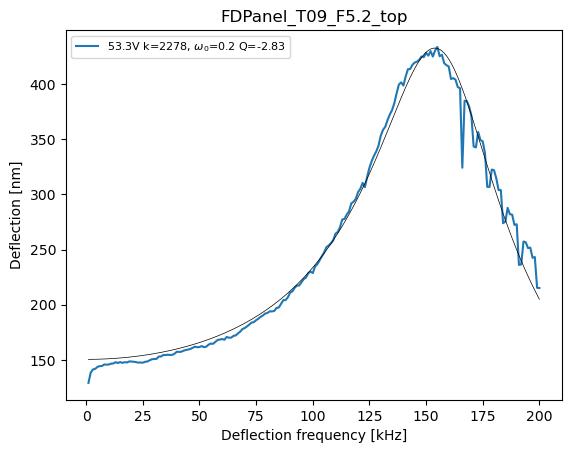

In [73]:

if 1:
    plt.figure()
    actuation_max_voltage = data_dict['actuation_max_voltage']
    # actuation_max_displacement = data_dict['actuation_max_displacement']
    
    
    frequencies = np.array(data_dict['signal_frequencies'])
    amplitude = np.array(data_dict['vibrometer_amplitude'])
    xdata,ydata = frequencies/1e3, amplitude/1e-9
    # fitting
    popt, pcov = curve_fit(fit_amplitude_response, xdata, ydata)
    
    F0,_,w0, Q = popt
    
    new_k = np.power(2*np.pi*w0,2)*mass
    fitdata = fit_amplitude_response(xdata, *popt)
    print(k, new_k)
    print('Calculated: %0.1fV k=%d, $\omega_0$=%0.1f Q=%0.2f'%(actuation_max_voltage, new_k, w0/1e3, Q))
    
    label = '%0.1fV k=%d, $\omega_0$=%0.1f Q=%0.2f'%(actuation_max_voltage, k, w0/1e3, Q)
    plt.plot(frequencies/1e3, amplitude/1e-9, label=label)

    plt.plot(xdata, fitdata, c='k', lw=0.5)
    
    if 'device_name' in data_dict.keys():
        title = data_dict['device_name']
        plt.title(title)
        output_figname = data_dict['device_name']+".png"
    plt.xlabel("Deflection frequency [kHz]")
    plt.ylabel("Deflection [nm]")
    plt.legend(fontsize=8)
    output_filefig = os.path.join(output_path, "%s.png"%filename%data_dict['actuation_max_voltage'])
    # plt.savefig(output_filefig, dpi=300)
    data_dict['fit_model_k'] = k
    data_dict['fit_model_f0'] = w0
    data_dict['fit_model_Q'] = Q


### Loading the data

### Amplitude response fit

From Practical MEMS:

(B.11):

$$ |x_0| = \frac{|F_0|/m}{\sqrt{ \left(\omega^2-\omega_0^2\right)^2 +\left(\omega\omega_0/Q\right)^2   }}  = \frac{|F_0|/k}{\sqrt{ \left(1-\frac{\omega^2}{\omega_0^2}\right)^2 +\left(\frac{\omega}{Q\omega_0}\right)^2   }}  $$

['FDPanel_T09_F5.2_top__actuation_18.8V.json', 'FDPanel_T09_F5.2_top__actuation_29.2V.json', 'FDPanel_T09_F5.2_top__actuation_34.2V.json']


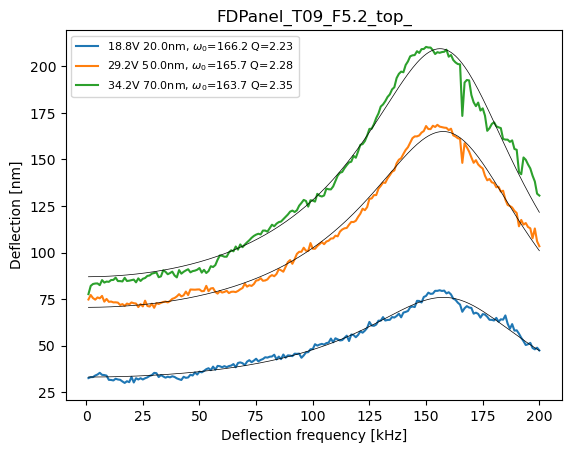

In [13]:

data_path = 'DAQ_outputs//'

file_prefix = "FDPanel_T09_F10.1_bottom"
file_prefix = "FDPanel_T09_F5.2_top"

files = os.listdir(data_path)
files = [d for d in files if ".json" in d]
files = [d for d in files if file_prefix in d]

print(files)
# Loop through existing files
for file in files:
    filename = os.path.join(data_path, file)
    data = open_data_file(filename)

    
    frequencies, amplitude = load_frequency_response(filename)
    actuation_max_voltage = data['actuation_max_voltage']
    actuation_max_displacement = data['actuation_max_displacement']
    
    
    xdata,ydata = frequencies/1e3, amplitude/1e-9
    # fitting
    popt, pcov = curve_fit(fit_amplitude_response, xdata, ydata)
    
    F0,k,w0, Q = popt
    fitdata = fit_amplitude_response(xdata, *popt)

    label = '%0.1fV %0.1fnm'%(actuation_max_voltage, actuation_max_displacement/1e-9)
    label = '%0.1fV %0.1fnm, $\omega_0$=%0.1f Q=%0.2f'%(actuation_max_voltage, actuation_max_displacement/1e-9, w0, Q)
    plt.plot(frequencies/1e3, amplitude/1e-9, label=label)

    plt.plot(xdata, fitdata, c='k', lw=0.5)
    
    if 'device_name' in data.keys():
        title = data['device_name']
        plt.title(title)

plt.xlabel("Deflection frequency [kHz]")
plt.ylabel("Deflection [nm]")
plt.legend(fontsize=8)

# Loop acquisition with audio recording

Assuming k=2278 for linearization
Running loop 

Progress: [####################] 100.0%
Storing files to  DAQ_outputs//testaudio_FDPanel_T09_F10.1_topacoustic_actuation_32.4V.json
Complete


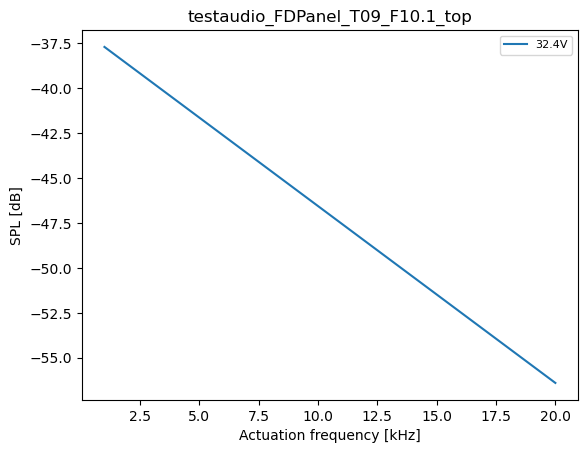

In [34]:
output_path = 'DAQ_outputs//'




frequency_list = np.linspace(1,20,2)*1e3


# select the displacement/voltage value expected at dc
max_displacement = 50*1e-9

data_dict = dict()

data_dict['device_name'] = "FDPanel_T09_F10.1_top"
data_dict['device_name'] = "testaudio_FDPanel_T09_F10.1_top"

filename = data_dict['device_name']+"acoustic_actuation_%0.1fV"


data_dict['date'] = "%s"%datetime.now()

data_dict['linearization_model_k'] = k
data_dict['linearization_model_mass'] = mass
data_dict['linearization_model_area'] = area
data_dict['linearization_model_gap'] = gap


print("Assuming k=%d for linearization"%(k))

# "acoustic" or "interferometer"
data_dict['measurement_type'] = "acoustic"

# data_dict['interferometer_system'] = "Polytec MSA-500"
# data_dict['interferometer_detector'] = 50e-9
# data_dict['interferometer_detector_units'] = "m/V"
# data_dict['interferometer_analog_filter_dc_block'] = True
# data_dict['interferometer_analog_filter_lowpass'] = False

data_dict['microphone_system'] = "MiniDSP UMIK-2"
data_dict['microphone_record_frequency'] = 192000
data_dict['microphone_record_duration'] = 0.1
data_dict['microphone_device_name'] = "Line (UMIK-2)"
data_dict['microhone_calibration_filename'] = "calibration/calibration_8101247.txt"
# data_dict['microphone_device'] = 
calibration_function = load_umik_calibration_function(data_dict['microhone_calibration_filename'])



data_dict['actuation_amplifier_gain'] = 53
data_dict['actuation_max_displacement'] = max_displacement



data_dict['actuation_max_voltage'] = linearization_function(data_dict['actuation_max_displacement'], 
                                                       gain=data_dict['actuation_amplifier_gain'], 
                                                       k=data_dict['linearization_model_k'], 
                                                       area=data_dict['linearization_model_area'], 
                                                       gap=data_dict['linearization_model_gap'])*data_dict['actuation_amplifier_gain']

# DAQ sampling acquisition
data_dict['daq_system'] = "NI USB-6363"
# data_dict['input_channel_names'] = ["ref_I", "ref_Q", "vibrometer"]
# data_dict['daq_input_channels'] = ["Dev1/ai0", "Dev1/ai1", "Dev1/ai2"]

data_dict['daq_input_channels'] = ["Dev1/ai0", ]
data_dict['daq_input_channel_names'] = ["ref_I",]
data_dict['daq_input_fs'] = 500e3
data_dict['daq_input_number_of_samples'] = 2000
data_dict['daq_input_sample_rate'] = -1
data_dict['daq_input_sample_interval'] = -1

data_dict['daq_output_channels'] = ["Dev1/ao0"]
data_dict['daq_output_channel_names'] = ["V_actuation"]
data_dict['daq_output_fs'] = 2e6
data_dict['daq_output_waveform_periods'] = 10


data_dict['signal_frequencies'] = frequency_list
# acquired signal will be stored inside the 'signal' key
data_dict['signal'] = dict()

# data_dict['vibrometer_amplitude'] = []
data_dict['microphone_frequency_peak_spl'] = []

print("Running loop ")
print("")
for f_i, frequency in enumerate(frequency_list):
    
    progress_bar(f_i/len(frequency_list))
    # Create actuation waveform
    fs = data_dict['daq_output_fs']
    
    t_max = data_dict['daq_output_waveform_periods']/frequency

    N = int(t_max*fs)
    t = np.linspace(0,t_max,N)

    
    # data = generate_waveform_signal(t, frequency, max_displacement)

    
    sig_sine = generate_sinusoidal_signal(t, frequency, data_dict['actuation_max_displacement'])
    sig_linearized = linearization_function(sig_sine, 
                                           gain=data_dict['actuation_amplifier_gain'], 
                                           k=data_dict['linearization_model_k'], 
                                           area=data_dict['linearization_model_area'], 
                                           gap=data_dict['linearization_model_gap'])*data_dict['actuation_amplifier_gain']
    data = sig_linearized/data_dict['actuation_amplifier_gain']
    
    with ni.Task() as read_task, ni.Task() as write_task, ni.Task() as trigger_task:

        # set channels
        for chan_input, chan_name in zip(data_dict['daq_input_channels'], data_dict['daq_input_channel_names']):
            read_task.ai_channels.add_ai_voltage_chan(chan_input, name_to_assign_to_channel=chan_name)

        for chan_output, chan_name in zip(data_dict['daq_output_channels'], data_dict['daq_output_channel_names']):
            write_task.ao_channels.add_ao_voltage_chan(chan_output, name_to_assign_to_channel=chan_name)


        # Set sampling frequency and Continuous output mode to continuously generate the same waveform
        write_task.timing.cfg_samp_clk_timing(data_dict['daq_output_fs'], sample_mode=ni.constants.AcquisitionType.CONTINUOUS)

        # Set the acquisiton sampling frequency with a finite acquisition
        read_task.timing.cfg_samp_clk_timing(data_dict['daq_input_fs'], sample_mode=ni.constants.AcquisitionType.FINITE, samps_per_chan=data_dict['daq_input_number_of_samples'])

        # Set the acquisiton trigger to start synchronized with the writing of the waveform
        
        read_task.triggers.start_trigger.cfg_dig_edge_start_trig(write_task.triggers.start_trigger.term, trigger_edge=ni.constants.Edge.FALLING)

        # set an arbitrary TICKS time after write
        wait_time_after_write = 3000000

        read_task.triggers.start_trigger.delay = wait_time_after_write
        # print(read_task.triggers.start_trigger.delay_units)

        # Write waveform data to output buffer
        write_task.write(data)

        # Get the actual sample rate and sample interval from the daq
        sample_clk_rate = read_task.timing.samp_clk_rate
        dt = 1/sample_clk_rate
        
        
        data_dict['daq_input_sample_rate'] = sample_clk_rate
        data_dict['daq_input_sample_interval'] = dt
        # print(sample_clk_rate, dt)

        read_task.start()

        write_task.start()
        
        
        # Read the acoustic microphone
        recording, dt = record_audio(device_str=data_dict['microphone_device_name'], fs=data_dict['microphone_record_frequency'], duration=data_dict['microphone_record_duration'],verbose=False )
        rec_freqs, rec_fft = recording2spectrum(recording, dt)
        rec_db = signal2db(rec_fft)
        _, rec_spl = microphone_calibrate(rec_freqs, rec_db, calibration_function)
        microphone_frequency_peak_spl = find_value_frequency(rec_freqs, rec_spl, frequency)

        # Read data
        read_data = read_task.read(number_of_samples_per_channel=ni.constants.READ_ALL_AVAILABLE)

        time.sleep(0.01)
        # set output to 0
        write_task.stop()
        write_task.write([0,0])
        write_task.start()
        # print("len readdata", len(read_data))

    
    
    data_dict['signal'][f_i] = dict()
    data_dict['signal'][f_i]['frequency'] = frequency
    sig_name = data_dict['daq_input_channel_names'][0]
    sig = read_data
    data_dict['signal'][f_i][sig_name] = sig

    # for i, (sig_name, sig) in enumerate(zip(data_dict['daq_input_channel_names'], read_data)):
    #     print(sig_name)
        # data_dict['signal'][f_i][sig_name] = sig
        # print("")
        # print("signalmax", np.ptp(sig))
    # print(sig)
    # data_dict['signal_time'] = np.arange(len(sig))*data_dict['daq_input_sample_interval']
    
    data_dict['signal'][f_i]["microphone_spl"] = rec_spl
    data_dict['signal'][f_i]["microphone_freqs"] = rec_freqs
    data_dict['signal'][f_i]["microphone_frequency_peak_spl"] = frequency_peak_spl 
    
    # Scaling reference signal with amplifier gain
    data_dict['signal'][f_i]['ref_I'] = np.array(data_dict['signal'][f_i]['ref_I'])*data_dict['actuation_amplifier_gain']
    
    data_dict['microphone_frequency_peak_spl'].append(microphone_frequency_peak_spl)
progress_bar(1)

max_voltage = data_dict['actuation_max_voltage'] 
output_filename = os.path.join(output_path, "%s.json"%filename%data_dict['actuation_max_voltage'])



if 1:
    plt.figure()
    actuation_max_voltage = data_dict['actuation_max_voltage']
    # actuation_max_displacement = data_dict['actuation_max_displacement']
    
    
    frequencies = np.array(data_dict['signal_frequencies'])
    amplitude = np.array(data_dict['microphone_frequency_peak_spl'])
    
    label = '%0.1fV'%(actuation_max_voltage, )
    plt.plot(frequencies/1e3, amplitude, label=label)

    if 'device_name' in data_dict.keys():
        title = data_dict['device_name']
        plt.title(title)
        output_figname = data_dict['device_name']+".png"
    plt.xlabel("Actuation frequency [kHz]")
    plt.ylabel("SPL [dB]")
    plt.legend(fontsize=8)
    output_filefig = os.path.join(output_path, "%s.png"%filename%data_dict['actuation_max_voltage'])
    # plt.savefig(output_filefig, dpi=300)
    
    
print("Storing files to ", output_filename)

with open(output_filename, 'w') as fp:
    json.dump(data_dict, fp, cls=NumpyArrayEncoder, indent=4)

print("Complete")
    
# data_dict.keys()

Text(0.5, 0, 'Frequency [Hz]')

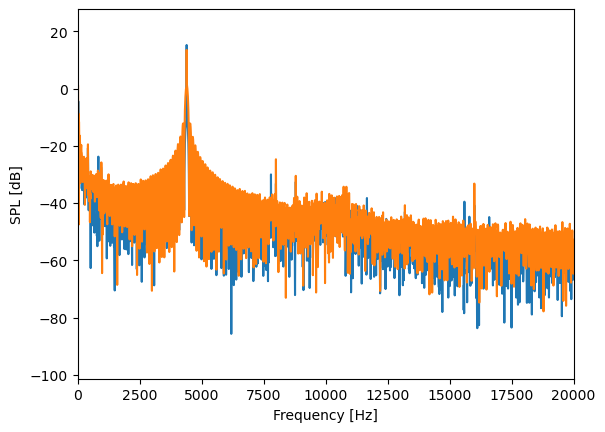

In [35]:
for f_i, f in enumerate(data_dict['signal_frequencies']):
    spl = data_dict['signal'][f_i]["microphone_spl"]
    freqs = data_dict['signal'][f_i]["microphone_freqs"]
    
    plt.plot(freqs, spl, label=f)
plt.xlim(0,20000)
plt.ylabel("SPL [dB]")
plt.xlabel("Frequency [Hz]")

In [40]:
recording.ptp()

0.006591796875

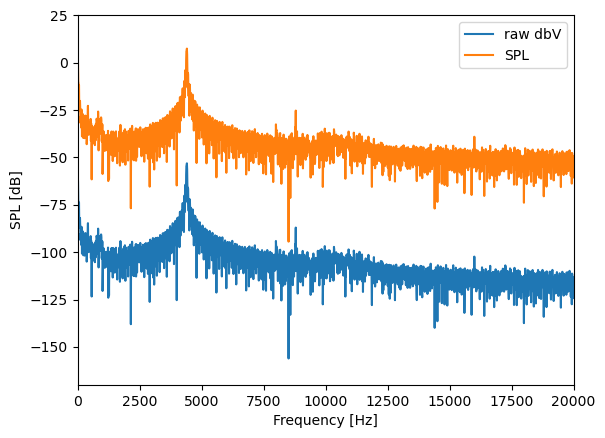

In [37]:
microphone_voltage_max = 
# Read the acoustic microphone
recording, dt = record_audio(device_str=data_dict['microphone_device_name'], fs=data_dict['microphone_record_frequency'], duration=data_dict['microphone_record_duration'],verbose=False )
rec_freqs, rec_fft = recording2spectrum(recording, dt)
rec_db = signal2db(rec_fft)
_, rec_spl = microphone_calibrate(rec_freqs, rec_db, calibration_function)
microphone_frequency_peak_spl = find_value_frequency(rec_freqs, rec_spl, frequency)



plt.plot(rec_freqs, rec_db, label="raw dbV")
plt.plot(rec_freqs, rec_spl, label="SPL")
plt.xlim(0,20000)
plt.ylabel("SPL [dB]")
plt.xlabel("Frequency [Hz]")
plt.legend()

## Reading audio from microphone

In [140]:
calibration_filename = "calibration/calibration_8101247.txt"


data_dict['microphone_system'] = "MiniDSP UMIK-2"
data_dict['microphone_frequency'] = 192000
data_dict['microphone_device_name'] = "Line (UMIK-2), MME"
'] = "calibration/calibration_8101247.txt"

calibration_function = load_umik_calibration_function(calibration_filename)

# f,calib = calibrate(f, )






NameError: name 'data_dict' is not defined

Selected device: 0 Microsoft Sound Mapper - Input


In [142]:
# recording, dt

In [143]:
t = np.arange(1000)*dt
A = 0.2
B = 17e-3
f = 25e3
f2 = 17e3
recording = A*np.sin(2*np.pi*t*f) + B*np.sin(2*np.pi*t*f2)

Selected device: 0 Microsoft Sound Mapper - Input
25000.0 -126.561139837816 17000.0 -94.08109260129761


Text(0, 0.5, 'Amplitude [dB]')

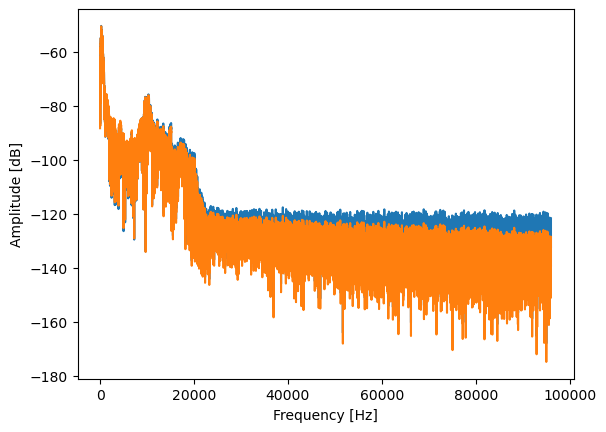

In [155]:
recording, dt = record_audio("")

rec_freqs, rec_fft = recording2spectrum(recording, dt)

rec_fft_db = signal2db(rec_fft)

calib_freqs, calib_rec = calibrate(rec_freqs, rec_fft_db, calibration_function)


val1 = find_value_frequency(rec_freqs, rec_fft_db, f)
val2 = find_value_frequency(rec_freqs, rec_fft_db, f2)

print(f, val1,f2, val2)
plt.plot(rec_freqs, rec_fft_db)
plt.plot(calib_freqs, calib_rec)
# plt.xlim(xmin=0)

plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [dB]")


Selected device: 1 Microphone Array (Realtek High 


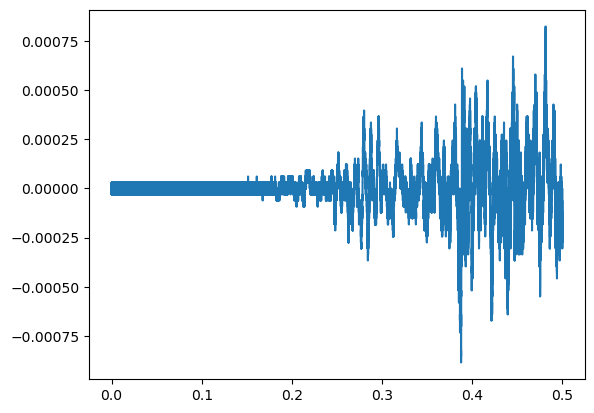

In [26]:
import sounddevice as sd
import numpy as np
import scipy.io.wavfile as wav


# print(sd.query_devices())

device_list = sd.query_devices()

# find and select index of Line (UMIK-2)
device_str = "Line (UMIK-2), MME"
device_str = 'Microphone Array (Realtek High '
# device_index = 0 
# device_name = 0 
for device in device_list:
    # print(device)
    if device_str in device["name"]:
        device_name = device["name"]
        device_index = device["index"]
        break
print("Selected device:",device_index,device_name)
sd.default.device = device_index



fs_recording = 192000
dt_recording = 1/fs_recording
duration = 0.5 #

N_recording = int(fs_recording*duration)

# Start recording:

recording = sd.rec(N_recording, samplerate=fs_recording, channels=1, dtype='float64')
time_recording = np.arange(len(recording))*dt_recording

# wait for recording to complete
sd.wait()


plt.plot(time_recording, recording)

In [15]:
fs=192000*2
duration = 0.5  # seconds


recording = sd.rec(duration * fs, samplerate=fs, channels=1,dtype='float64')
print ("Recording Audio from speaker")
sd.wait()
plt.plot(recording)
# plt.plot(myrecording[:,1])
print ("Audio recording complete , Play Audio")
sd.play(recording, fs)
sd.wait()
print ("Play Audio Complete")

TypeError: 'float' object cannot be interpreted as an integer

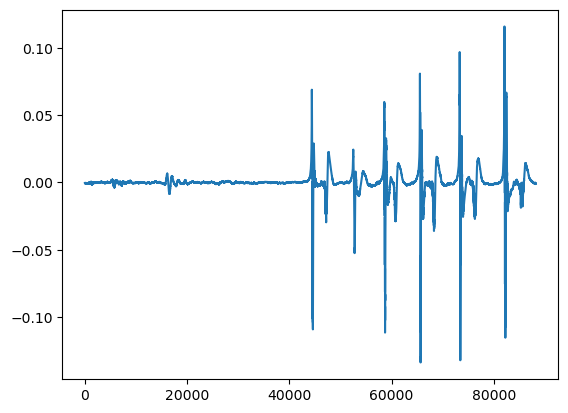

In [127]:
plt.plot(myrecording[:,0])

# Generate single waveform

press enter to stop.
 


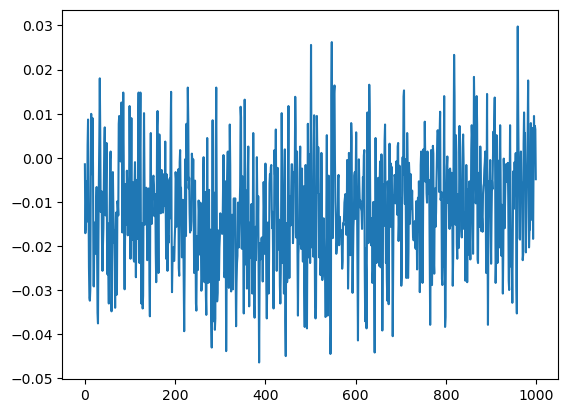

In [34]:
# def set_output_signal(max_displacement, frequency):

frequency = 100e3
max_displacement = 60e-9

fs = 2e6

t_max = 10/frequency

N = int(t_max*fs)
t = np.linspace(0,t_max,N)



data = generate_waveform_signal(t, frequency, max_displacement)

with ni.Task() as read_task, ni.Task() as write_task, ni.Task() as trigger_task:

    # set channels
    # for chan_input, chan_name in zip(data_dict['daq_input_channels'], data_dict['daq_input_channel_names']):
    read_task.ai_channels.add_ai_voltage_chan("Dev1/ai2")

    # for chan_output, chan_name in zip(data_dict['daq_output_channels'], data_dict['daq_output_channel_names']):
    write_task.ao_channels.add_ao_voltage_chan("Dev1/ao0")


    # Set sampling frequency and Continuous output mode to continuously generate the same waveform
    write_task.timing.cfg_samp_clk_timing(fs, sample_mode=ni.constants.AcquisitionType.CONTINUOUS)

    # Set the acquisiton sampling frequency with a finite acquisition
    read_task.timing.cfg_samp_clk_timing(fs, sample_mode=ni.constants.AcquisitionType.FINITE, samps_per_chan=1000)

    # Set the acquisiton trigger to start synchronized with the writing of the waveform
    # write_task.triggers.start_trigger.cfg_dig_edge_start_trig(term_trigger, trigger_edge=ni.constants.Edge.RISING)
    read_task.triggers.start_trigger.cfg_dig_edge_start_trig(write_task.triggers.start_trigger.term, trigger_edge=ni.constants.Edge.FALLING)

#     # set an arbitrary TICKS time after write
    wait_time_after_write = 5000000

    read_task.triggers.start_trigger.delay = wait_time_after_write
    # print(read_task.triggers.start_trigger.delay_units)

    # Write waveform data to output buffer
    write_task.write(data)
    
    # write_task.start()
    
    
#     # Get the actual sample rate and sample interval from the daq
#     sample_clk_rate = read_task.timing.samp_clk_rate
#     dt = 1/sample_clk_rate


#     data_dict['daq_input_sample_rate'] = sample_clk_rate
#     data_dict['daq_input_sample_interval'] = dt
#     # print(sample_clk_rate, dt)

    read_task.start()

    write_task.start()



#     # Read data
    data = read_task.read(number_of_samples_per_channel=ni.constants.READ_ALL_AVAILABLE)


    # while 1:
    #     continue
        
    sec = input('press enter to stop.\n')



#     # set output to 0
#     write_task.stop()
#     write_task.write([0,0])
#     write_task.start()
plt.plot(data)

## Plot frequency response

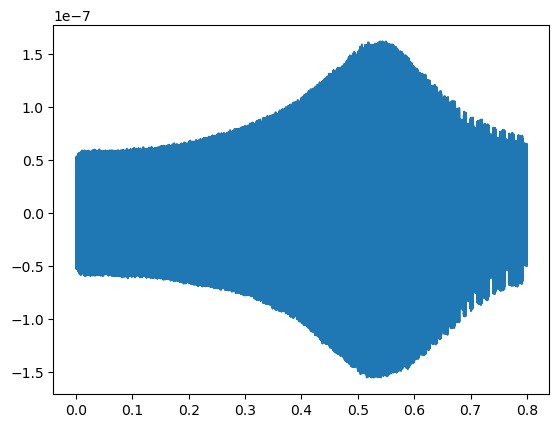

In [7]:
time, vibrometer = load_time_signal_data_concatenated(filename)

plt.plot(time, vibrometer)

# Plot spectrogram


In [289]:
np.percentile(sig, 99)

0.5693563763574337

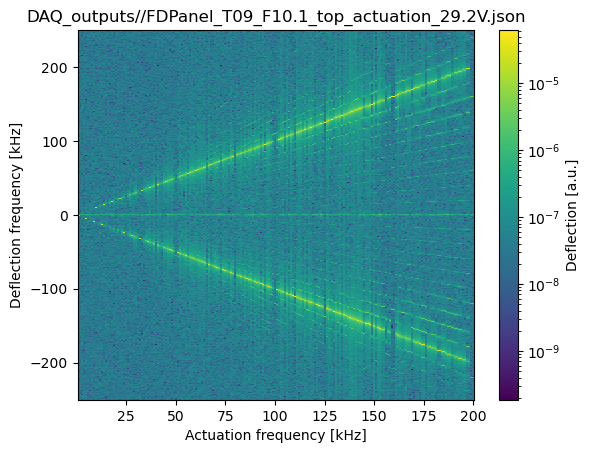

In [309]:

frequencies, vibration_freqs, vibration_spectrum = load_frequency_deflection_spectrum(filename)

vibration_spectrum = np.abs(vibration_spectrum)

plt.title(filename)
plt.pcolormesh(frequencies/1e3, vibration_freqs/1e3, vibration_spectrum, norm=colors.LogNorm(vmin=vibration_spectrum.min(), vmax=vibration_spectrum.max()))
# plt.pcolormesh(f_list, freqs, mag_fft.T)

plt.xlabel("Actuation frequency [kHz]")
plt.ylabel("Deflection frequency [kHz]")

plt.colorbar(label='Deflection [a.u.]')
# plt.colorbar(label='Actuation voltage [a.u.]')



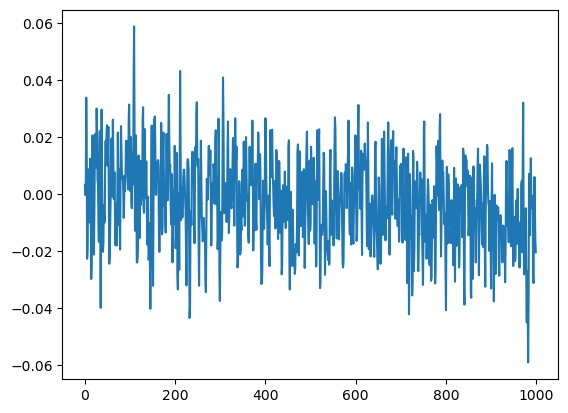

In [9]:
plt.plot(data)

In [10]:
# plt.figure(figsize=(10,2))


    reference = np.array(data[0])
    vibrometer = np.array(data[1])

    scale_reference = 53 # V/V

    vibrometer_detector = 50 # nm/V

    scale_vibrometer = -1* vibrometer_detector

    reference *= scale_reference
    vibrometer *= scale_vibrometer
    vibrometer -= vibrometer.min()

    t = np.arange(len(reference))*dt
    
    
    reference_list.append(reference)
    time_list.append(t)
    vibrometer_list.append(vibrometer)
    

fig, axes = plt.subplots(3,1,)

plt.sca(axes[0])

plt.plot(t, reference, '-')
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")

plt.sca(axes[1])
plt.plot(t, vibrometer, '-')
plt.xlabel("Time [s]")
plt.ylabel("Voltage [nm]")

plt.sca(axes[2])
plt.plot(reference, vibrometer, '-')
plt.xlabel("Voltage [V]")
plt.ylabel("Deflection [nm]")

    

IndentationError: unexpected indent (3219415832.py, line 4)

NameError: name 'f_list' is not defined

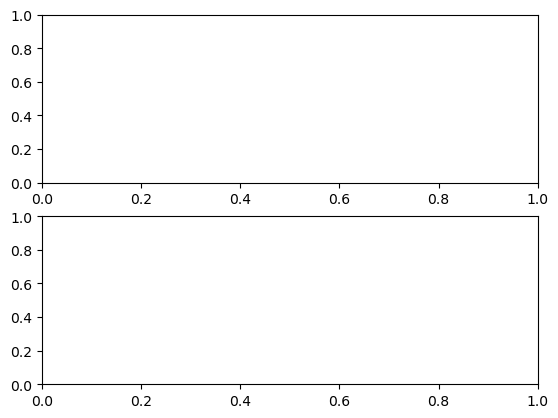

In [11]:

fig, axes = plt.subplots(2,1,)


max_deflection = []
for i, (f_displacement, time, reference, vibrometer) in enumerate(zip(f_list,time_list, reference_list, vibrometer_list)):
    
    max_deflection.append(vibrometer.max())
    
    # plt.sca(axes[0])
    # plt.plot(reference, vibrometer, '-')
    # plt.xlabel("Voltage [V]")
    # plt.ylabel("Deflection [nm]")
print(i)
plt.sca(axes[1])

plt.plot(f_list, max_deflection)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Deflection [nm]")

max_deflection = []
newi = i+1
for i, (f_displacement, time, reference, vibrometer) in enumerate(zip(f_list,time_list[newi:], reference_list[newi:], vibrometer_list[newi:])):
    
    max_deflection.append(vibrometer.max())
    
    # plt.sca(axes[0])
    # plt.plot(reference, vibrometer, '-')
    # plt.xlabel("Voltage [V]")
    # plt.ylabel("Deflection [nm]")
print(i)
plt.sca(axes[1])

plt.plot(f_list, max_deflection)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Deflection [nm]")


In [82]:
from scipy import signal, fft
from matplotlib import colors


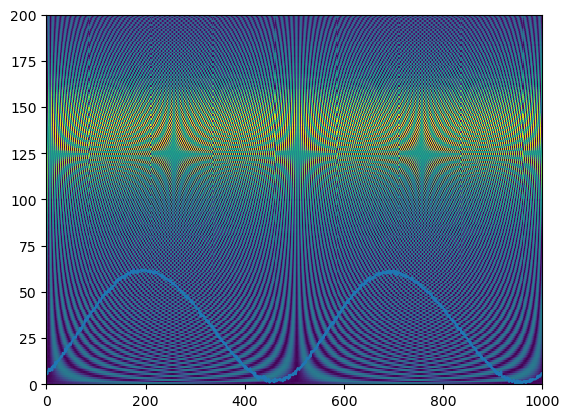

In [83]:
z = np.array(vibrometer_list)
z.shape

plt.pcolormesh(z)

plt.plot(z[0,:])



In [124]:

fft_list = []
# for vib in vibrometer_list[:]:
for i, (f_displacement, time, reference, vibrometer) in enumerate(zip(f_list,time_list, reference_list, vibrometer_list)):

    dt = np.diff(time[:2])
    vib_fft = fft.rfft(vibrometer, norm="ortho")
    
    freqs = fft.fftfreq(vib_fft.size, d=dt)
    vib_fft = fft.fftshift(vib_fft)
    freqs = fft.fftshift(freqs)
    
    vib_fft = abs(vib_fft)
    vib_fft /= vib_fft.max()
    
    fft_list.append(vib_fft)
    # plt.plot(freqs,vib_fft)
    
    
fft_list = np.array(fft_list)

mag_fft = abs(fft_list)
    

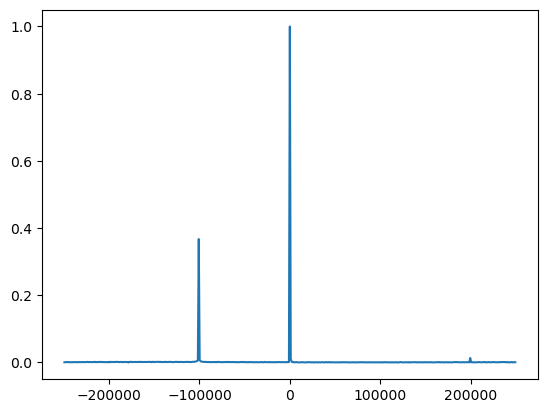

In [126]:
# plt.plot(freqs, vib_fft)
plt.plot(freqs,abs(vib_fft))

In [127]:
fft_list.shape, freqs.shape, f_list.shape, mag_fft

((200, 501),
 (501,),
 (200,),
 array([[5.07799081e-04, 7.96450782e-04, 2.70782286e-04, ...,
         1.92291968e-04, 6.76869730e-04, 1.07751972e-03],
        [4.60822899e-04, 6.25596610e-04, 2.50390976e-04, ...,
         7.22589092e-04, 6.65582645e-04, 2.47294450e-04],
        [6.96251518e-04, 6.90909064e-05, 7.73929203e-05, ...,
         5.87329845e-04, 1.84380416e-04, 4.93865568e-04],
        ...,
        [8.84237032e-04, 1.36445935e-03, 1.36343888e-03, ...,
         1.05822694e-03, 1.12894729e-03, 5.22657820e-04],
        [5.35711349e-04, 1.29978417e-03, 1.05121316e-03, ...,
         7.51890259e-04, 1.59805398e-03, 8.22853656e-04],
        [5.27065088e-04, 1.04004776e-03, 1.21601931e-03, ...,
         9.93045083e-04, 7.09756805e-04, 7.75676626e-04]]))

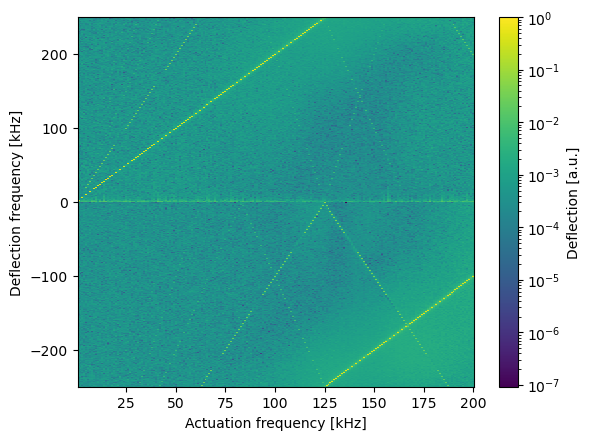

In [128]:
plt.pcolormesh(f_list/1e3, freqs/1e3, mag_fft.T, norm=colors.LogNorm(vmin=mag_fft.min(), vmax=mag_fft.max()))
# plt.pcolormesh(f_list, freqs, mag_fft.T)

plt.xlabel("Actuation frequency [kHz]")
plt.ylabel("Deflection frequency [kHz]")

plt.colorbar(label='Deflection [a.u.]')

In [130]:
import json

In [129]:
fs = fs_input
nfft = 2048
noverlap = 120
nperseg = 128
f, t, Sxx = signal.spectrogram(z, fs=fs, nperseg=nperseg, nfft=nfft, noverlap=noverlap)

# plt.pcolormesh(Sxx)

In [47]:
Sxx.shape, f.shape, t.shape

((400, 1025, 110), (1025,), (110,))

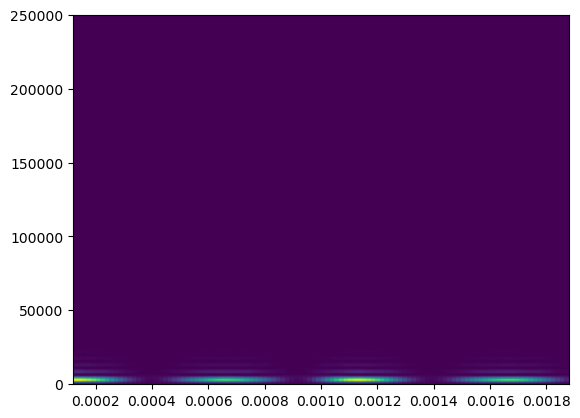

In [48]:
plt.pcolormesh(t,f, Sxx[0])